In [2]:
#import necessary libraries and files 
import pandas as pd
import numpy as np
import warnings
import time
import datetime as dt
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
#import folium
import sklearn
import seaborn as sns

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans


%matplotlib inline

In [5]:
station_data = pd.read_csv("station_data.csv")

In [6]:
station_data

,STATION ID,TIME,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,cluster,usage
0,89,2018-08-01 12:30:02,2018-08-01 12:19:52,FITZWILLIAM SQUARE EAST,40,3,37,Open,Fitzwilliam Square East,53.335213,-6.250900,0.0,NaN
1,89,2018-08-01 12:35:02,2018-08-01 12:31:35,FITZWILLIAM SQUARE EAST,40,4,36,Open,Fitzwilliam Square East,53.335213,-6.250900,0.0,1.0
2,89,2018-08-01 12:40:02,2018-08-01 12:34:03,FITZWILLIAM SQUARE EAST,40,3,37,Open,Fitzwilliam Square East,53.335213,-6.250900,0.0,1.0
3,89,2018-08-01 12:45:02,2018-08-01 12:34:03,FITZWILLIAM SQUARE EAST,40,3,37,Open,Fitzwilliam Square East,53.335213,-6.250900,0.0,0.0
4,89,2018-08-01 12:50:02,2018-08-01 12:45:54,FITZWILLIAM SQUARE EAST,40,3,37,Open,Fitzwilliam Square East,53.335213,-6.250900,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059651,52,2022-01-01 23:35:02,2022-01-01 23:26:25,YORK STREET EAST,32,22,10,Open,York Street East,53.338757,-6.262003,1.0,0.0
2059652,52,2022-01-01 23:40:02,2022-01-01 23:36:32,YORK STREET EAST,32,22,10,Open,York Street East,53.338757,-6.262003,1.0,0.0
2059653,52,2022-01-01 23:45:02,2022-01-01 23:36:32,YORK STREET EAST,32,22,10,Open,York Street East,53.338757,-6.262003,1.0,0.0
2059654,52,2022-01-01 23:50:02,2022-01-01 23:46:37,YORK STREET EAST,32,22,10,Open,York Street East,53.338757,-6.262003,1.0,0.0


In [7]:
data = station_data.copy()

In [8]:
data.NAME.unique()

array(['FITZWILLIAM SQUARE EAST', 'HANOVER QUAY', 'MATER HOSPITAL',
       'NEW CENTRAL BANK', 'PARNELL SQUARE NORTH', 'YORK STREET EAST'],
      dtype=object)

### Data preprocessing

In [9]:
#cluster stations
#data = data[data['STATUS'] == 'Open']

#?
#remove rows where no update actually occurs
#data = data.drop(['LAST UPDATED'], axis = 1)
data.drop_duplicates(keep= 'first',inplace=True)

dates = [dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in data["TIME"]]
#get date and time columns
data['datetime'] = dates
data['time'] = data.datetime.dt.time
#data['time'] = [dt.datetime.time(d) for d in data['DATETIME']] 
data['date'] = data.datetime.dt.date
#data['date'] = [dt.datetime.date(d) for d in data['DATETIME']] 
data['date_for_merge'] = data.datetime.dt.round('d')


startDate = min(dates).date()
#create important features
data['OCCUPANCY_PCT'] =  data['AVAILABLE BIKES'] / data['BIKE STANDS']
data['FULL'] = np.where(data['OCCUPANCY_PCT'] == 0, 1,0 )
data['EMPTY'] = np.where(data['OCCUPANCY_PCT'] == 1, 1,0 )

### create time aggregates needed for clustering
# weekday/saturday/sunday
data['day_number'] = data.datetime.dt.dayofweek
data['day_type'] = np.where(data['day_number'] <= 4, 'Weekday', (np.where(data['day_number'] == 5, 'Saturday', 'Sunday')))

def bin_time(x):
    if x.time() < dt.time(6):
        return "Overnight "
    elif x.time() < dt.time(11):
        return "6AM-10AM "
    elif x.time() < dt.time(16):
        return "11AM-3PM "
    elif x.time() < dt.time(20):
        return "4PM-7PM "
    elif x.time() <= dt.time(23):
        return "8PM-11PM "
    else:
        return "Overnight "

data["time_type"] = data.datetime.apply(bin_time)
data['hour'] = data.datetime.dt.hour
data['month'] = data.datetime.dt.month
data['week'] = data.datetime.dt.week
data['year'] = data.datetime.dt.year
data['dayIndex'] = [(d - startDate).days for d in data['date']]

In [10]:
data.head()

,STATION ID,TIME,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,...,FULL,EMPTY,day_number,day_type,time_type,hour,month,week,year,dayIndex
0,89,2018-08-01 12:30:02,2018-08-01 12:19:52,FITZWILLIAM SQUARE EAST,40,3,37,Open,Fitzwilliam Square East,53.335213,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
1,89,2018-08-01 12:35:02,2018-08-01 12:31:35,FITZWILLIAM SQUARE EAST,40,4,36,Open,Fitzwilliam Square East,53.335213,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
2,89,2018-08-01 12:40:02,2018-08-01 12:34:03,FITZWILLIAM SQUARE EAST,40,3,37,Open,Fitzwilliam Square East,53.335213,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
3,89,2018-08-01 12:45:02,2018-08-01 12:34:03,FITZWILLIAM SQUARE EAST,40,3,37,Open,Fitzwilliam Square East,53.335213,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
4,89,2018-08-01 12:50:02,2018-08-01 12:45:54,FITZWILLIAM SQUARE EAST,40,3,37,Open,Fitzwilliam Square East,53.335213,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0


In [11]:
data.columns

Index(['STATION ID', 'TIME', 'LAST UPDATED', 'NAME', 'BIKE STANDS',
       'AVAILABLE BIKE STANDS', 'AVAILABLE BIKES', 'STATUS', 'ADDRESS',
       'LATITUDE', 'LONGITUDE', 'cluster', 'usage', 'datetime', 'time', 'date',
       'date_for_merge', 'OCCUPANCY_PCT', 'FULL', 'EMPTY', 'day_number',
       'day_type', 'time_type', 'hour', 'month', 'week', 'year', 'dayIndex'],
      dtype='object')

### Creating Dataframes for each cluster

Clusters 0, 1, 2

In [62]:
cluster0.dropna(inplace=True)
cluster1.dropna(inplace=True)
cluster2.dropna(inplace=True)

In [54]:
mask_cluster0 = data.cluster == 0 
mask_cluster1 = data.cluster == 1
mask_cluster2 = data.cluster == 2

cluster0 = data[mask_cluster0]
cluster1 = data[mask_cluster1]
cluster2 = data[mask_cluster2]

# Masking taken from tutorial 2 of ML 

,STATION ID,TIME,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,...,FULL,EMPTY,day_number,day_type,time_type,hour,month,week,year,dayIndex
686080,78,2018-08-01 12:30:02,2018-08-01 12:19:41,MATER HOSPITAL,40,37,3,Open,Mater Hospital,53.359966,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
686081,78,2018-08-01 12:35:02,2018-08-01 12:29:49,MATER HOSPITAL,40,37,3,Open,Mater Hospital,53.359966,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
686082,78,2018-08-01 12:40:02,2018-08-01 12:29:49,MATER HOSPITAL,40,37,3,Open,Mater Hospital,53.359966,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
686083,78,2018-08-01 12:45:02,2018-08-01 12:42:12,MATER HOSPITAL,40,36,4,Open,Mater Hospital,53.359966,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
686084,78,2018-08-01 12:50:02,2018-08-01 12:42:12,MATER HOSPITAL,40,36,4,Open,Mater Hospital,53.359966,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715970,30,2022-01-01 23:35:02,2022-01-01 23:34:49,PARNELL SQUARE NORTH,20,9,11,Open,Parnell Square North,53.353462,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249
1715971,30,2022-01-01 23:40:02,2022-01-01 23:38:06,PARNELL SQUARE NORTH,20,8,12,Open,Parnell Square North,53.353462,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249
1715972,30,2022-01-01 23:45:02,2022-01-01 23:38:06,PARNELL SQUARE NORTH,20,8,12,Open,Parnell Square North,53.353462,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249
1715973,30,2022-01-01 23:50:02,2022-01-01 23:48:12,PARNELL SQUARE NORTH,20,8,12,Open,Parnell Square North,53.353462,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249


### Creating data frames or each station

"HANOVER QUAY"

"FITZWILLIAM SQUARE EAST"

"MATER HOSPITAL"

"NEW CENTRAL BANK"

"PARNELL SQUARE NORTH" 

"YORK STREET EAST"

In [21]:
mask_hanover = data.NAME == "HANOVER QUAY"
mask_fitzwilliam = data.NAME == "FITZWILLIAM SQUARE EAST"
mask_mater = data.NAME == "MATER HOSPITAL"

hanover_data = data[mask_hanover]
fitzwilliam_data = data[mask_fitzwilliam]
mater_data = data[mask_mater]

In [22]:
hanover_data['usage'] = hanover_data['AVAILABLE BIKES'].diff()
hanover_data

,STATION ID,TIME,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,...,FULL,EMPTY,day_number,day_type,time_type,hour,month,week,year,dayIndex
342454,68,2018-08-01 12:30:02,2018-08-01 12:24:49,HANOVER QUAY,40,3,37,Open,Hanover Quay,53.344116,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
342455,68,2018-08-01 12:35:02,2018-08-01 12:24:49,HANOVER QUAY,40,3,37,Open,Hanover Quay,53.344116,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
342456,68,2018-08-01 12:40:02,2018-08-01 12:37:22,HANOVER QUAY,40,2,38,Open,Hanover Quay,53.344116,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
342457,68,2018-08-01 12:45:02,2018-08-01 12:37:22,HANOVER QUAY,40,2,38,Open,Hanover Quay,53.344116,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
342458,68,2018-08-01 12:50:02,2018-08-01 12:48:24,HANOVER QUAY,40,2,38,Open,Hanover Quay,53.344116,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686075,68,2022-01-01 23:35:02,2022-01-01 23:31:51,HANOVER QUAY,40,21,19,Open,Hanover Quay,53.344116,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249
686076,68,2022-01-01 23:40:02,2022-01-01 23:31:51,HANOVER QUAY,40,21,19,Open,Hanover Quay,53.344116,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249
686077,68,2022-01-01 23:45:02,2022-01-01 23:41:57,HANOVER QUAY,40,21,19,Open,Hanover Quay,53.344116,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249
686078,68,2022-01-01 23:50:02,2022-01-01 23:45:15,HANOVER QUAY,40,21,19,Open,Hanover Quay,53.344116,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249


In [23]:
hanover_data["usage"].isnull().sum()

1

In [24]:
fitzwilliam_data['usage'] = fitzwilliam_data['AVAILABLE BIKES'].diff()
fitzwilliam_data

,STATION ID,TIME,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,...,FULL,EMPTY,day_number,day_type,time_type,hour,month,week,year,dayIndex
0,89,2018-08-01 12:30:02,2018-08-01 12:19:52,FITZWILLIAM SQUARE EAST,40,3,37,Open,Fitzwilliam Square East,53.335213,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
1,89,2018-08-01 12:35:02,2018-08-01 12:31:35,FITZWILLIAM SQUARE EAST,40,4,36,Open,Fitzwilliam Square East,53.335213,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
2,89,2018-08-01 12:40:02,2018-08-01 12:34:03,FITZWILLIAM SQUARE EAST,40,3,37,Open,Fitzwilliam Square East,53.335213,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
3,89,2018-08-01 12:45:02,2018-08-01 12:34:03,FITZWILLIAM SQUARE EAST,40,3,37,Open,Fitzwilliam Square East,53.335213,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
4,89,2018-08-01 12:50:02,2018-08-01 12:45:54,FITZWILLIAM SQUARE EAST,40,3,37,Open,Fitzwilliam Square East,53.335213,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342449,89,2022-01-01 23:35:02,2022-01-01 23:25:57,FITZWILLIAM SQUARE EAST,40,25,15,Open,Fitzwilliam Square East,53.335213,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249
342450,89,2022-01-01 23:40:02,2022-01-01 23:36:03,FITZWILLIAM SQUARE EAST,40,25,15,Open,Fitzwilliam Square East,53.335213,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249
342451,89,2022-01-01 23:45:02,2022-01-01 23:36:03,FITZWILLIAM SQUARE EAST,40,25,15,Open,Fitzwilliam Square East,53.335213,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249
342452,89,2022-01-01 23:50:02,2022-01-01 23:46:09,FITZWILLIAM SQUARE EAST,40,25,15,Open,Fitzwilliam Square East,53.335213,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249


In [25]:
fitzwilliam_data["usage"].isnull().sum()

1

In [27]:
mater_data["usage"] = mater_data["AVAILABLE BIKES"].diff()
mater_data

,STATION ID,TIME,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,...,FULL,EMPTY,day_number,day_type,time_type,hour,month,week,year,dayIndex
686080,78,2018-08-01 12:30:02,2018-08-01 12:19:41,MATER HOSPITAL,40,37,3,Open,Mater Hospital,53.359966,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
686081,78,2018-08-01 12:35:02,2018-08-01 12:29:49,MATER HOSPITAL,40,37,3,Open,Mater Hospital,53.359966,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
686082,78,2018-08-01 12:40:02,2018-08-01 12:29:49,MATER HOSPITAL,40,37,3,Open,Mater Hospital,53.359966,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
686083,78,2018-08-01 12:45:02,2018-08-01 12:42:12,MATER HOSPITAL,40,36,4,Open,Mater Hospital,53.359966,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
686084,78,2018-08-01 12:50:02,2018-08-01 12:42:12,MATER HOSPITAL,40,36,4,Open,Mater Hospital,53.359966,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028945,78,2022-01-01 23:35:02,2022-01-01 23:26:15,MATER HOSPITAL,40,22,18,Open,Mater Hospital,53.359966,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249
1028946,78,2022-01-01 23:40:02,2022-01-01 23:36:21,MATER HOSPITAL,40,22,18,Open,Mater Hospital,53.359966,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249
1028947,78,2022-01-01 23:45:02,2022-01-01 23:36:21,MATER HOSPITAL,40,22,18,Open,Mater Hospital,53.359966,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249
1028948,78,2022-01-01 23:50:02,2022-01-01 23:46:27,MATER HOSPITAL,40,22,18,Open,Mater Hospital,53.359966,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249


In [28]:
mater_data["usage"].isnull().sum()

1

### Attempting to plot Hanover usage

In [29]:
hanover_data = hanover_data.dropna()
fitzwilliam_data = fitzwilliam_data.dropna()
mater_data = mater_data.dropna()

In [30]:
hanover_data.head()

,STATION ID,TIME,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,...,FULL,EMPTY,day_number,day_type,time_type,hour,month,week,year,dayIndex
342455,68,2018-08-01 12:35:02,2018-08-01 12:24:49,HANOVER QUAY,40,3,37,Open,Hanover Quay,53.344116,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
342456,68,2018-08-01 12:40:02,2018-08-01 12:37:22,HANOVER QUAY,40,2,38,Open,Hanover Quay,53.344116,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
342457,68,2018-08-01 12:45:02,2018-08-01 12:37:22,HANOVER QUAY,40,2,38,Open,Hanover Quay,53.344116,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
342458,68,2018-08-01 12:50:02,2018-08-01 12:48:24,HANOVER QUAY,40,2,38,Open,Hanover Quay,53.344116,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0
342459,68,2018-08-01 12:55:02,2018-08-01 12:50:02,HANOVER QUAY,40,1,39,Open,Hanover Quay,53.344116,...,0,0,2,Weekday,11AM-3PM,12,8,31,2018,0


In [31]:
hanover_data.tail()

,STATION ID,TIME,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,...,FULL,EMPTY,day_number,day_type,time_type,hour,month,week,year,dayIndex
686075,68,2022-01-01 23:35:02,2022-01-01 23:31:51,HANOVER QUAY,40,21,19,Open,Hanover Quay,53.344116,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249
686076,68,2022-01-01 23:40:02,2022-01-01 23:31:51,HANOVER QUAY,40,21,19,Open,Hanover Quay,53.344116,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249
686077,68,2022-01-01 23:45:02,2022-01-01 23:41:57,HANOVER QUAY,40,21,19,Open,Hanover Quay,53.344116,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249
686078,68,2022-01-01 23:50:02,2022-01-01 23:45:15,HANOVER QUAY,40,21,19,Open,Hanover Quay,53.344116,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249
686079,68,2022-01-01 23:55:02,2022-01-01 23:45:15,HANOVER QUAY,40,21,19,Open,Hanover Quay,53.344116,...,0,0,5,Saturday,Overnight,23,1,52,2022,1249


### Yearly bike usage

In [32]:
def total_year_bike_usage(yyyy, dataset):
    
     '''
    For example
    
    2021, hanover_data
    '''
    
    year_data = dataset[dataset.year == yyyy]
    usage = year_data["usage"]
    return(sum(abs(usage)))

In [111]:
total_year_bike_usage(2021, hanover_data)

34660.0

### Monthly bike usage

In [90]:
def total_monthly_bike_usage(yyyy, m, dataset):
     '''
    For example
    
    2018, 12, hanover_data
    '''
    
    year_data = dataset[dataset.year == yyyy]
    month_data = year_data[year_data.month == m]

    month_usage = month_data["usage"]
    return(sum(abs(month_usage)))
    
    #return(month_data.head())
    #return(month_data.tail())

In [35]:
total_monthly_bike_usage(2018, 12, hanover_data)

5517.0


In [36]:
total_monthly_bike_usage(2019, 3, hanover_data)

6560.0


### Weekly bike usage

In [91]:
def total_weekly_bike_usage(yyyy, w, dataset):
    
     '''
    For example
    
    2019, 27, hanover_data
    '''
    
    year_data = dataset[dataset.year == yyyy]
    week_data = year_data[year_data.week == w]

    week_usage = week_data["usage"]
    return(sum(abs(week_usage)))

In [38]:
total_weekly_bike_usage(2019, 27, hanover_data)

1909.0


### Day index bike usage

In [39]:
def total_dayindex_bike_usage(di, dataset):
    di_data = dataset[dataset.dayIndex == di]
    
    di_usage = di_data["usage"]
    print(sum(abs(di_usage)))
    
    #return(di_data.head())
    #return(di_data.tail())

In [41]:
total_dayindex_bike_usage(700, hanover_data)

105.0


### Date bike usage

In [42]:
def date_bike_usage(yyyymmdd, dataset):    
    '''
    For example
    
    "2021-01-04", hanover_data
    '''
    
    dates = pd.to_datetime(dataset.TIME, format = "%Y-%m-%d %H:%M:%S")
    date_vector = pd.DatetimeIndex(dates.dt.date)
    day_index = date_vector == yyyymmdd
    
    day_of_interest = dates[day_index]
    usage = dataset[day_index]["usage"]
    print(sum(abs(usage))) 

In [43]:
date_bike_usage("2021-01-04", hanover_data)

48.0


In [44]:
date_bike_usage("2021-07-04", hanover_data)

83.0


### Hourly bike usage

In [45]:
def hourly_bike_usage(yyyymmdd, hour, dataset):
    '''
    For example
    
    "2021-01-04", hanover_data
    '''
    date_data = dataset[dataset.year == yyyy]
    week_data = year_data[year_data.week == w]

    week_usage = week_data["usage"]
    print(sum(abs(week_usage)))
    

### Yearly usage data frame

In [46]:
years = [2018, 2019, 2020, 2021]

In [79]:
cluster0.dayIndex.nunique()

1205

In [78]:
cluster0["dayIndex"].unique()

array([   0,    1,    2, ..., 1247, 1248, 1249])

In [65]:
cluster0_usage = []
for i in years:
    cluster0_usage.append(total_year_bike_usage(i, cluster0))
print(cluster0_usage)

cluster1_usage = []
for i in years:
    cluster1_usage.append(total_year_bike_usage(i, cluster1))
print(cluster1_usage)

cluster2_usage = []
for i in years:
    cluster2_usage.append(total_year_bike_usage(i, cluster2))
print(cluster2_usage)


yudf = {
    'Year': years,
    "Cluster 0":cluster0_usage,
    "Cluster 1":cluster1_usage,
    "Cluster 2":cluster2_usage
}
yudf = pd.DataFrame(yudf)
print(yudf)

[50473.0, 97376.0, 44356.0, 42848.0]
[45496.0, 105071.0, 52888.0, 55208.0]
[23788.0, 53653.0, 36339.0, 34908.0]
   Year  Cluster 0  Cluster 1  Cluster 2
0  2018    50473.0    45496.0    23788.0
1  2019    97376.0   105071.0    53653.0
2  2020    44356.0    52888.0    36339.0
3  2021    42848.0    55208.0    34908.0


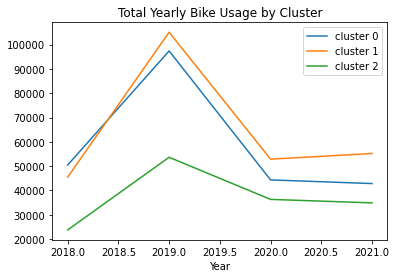

In [74]:
ax = plt.gca()

yudf.plot(x = "Year", y = "Cluster 0", label ="cluster 0", ax = ax)
yudf.plot(x = "Year", y = "Cluster 1", label ="cluster 1", ax = ax)
yudf.plot(x = "Year", y = "Cluster 2", label ="cluster 2", ax = ax)

plt.title("Total Yearly Bike Usage by Cluster")
plt.legend()
plt.show()

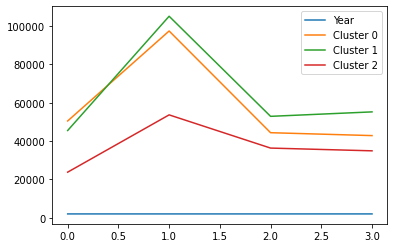

In [70]:
yudf.plot()

### Monthly usage data frame

In [98]:
months = range(1,13)

In [99]:
cluster0_usage = []
for i in months:
    cluster0_usage.append(total_monthly_bike_usage(2019, i, cluster0))
print(cluster0_usage)

cluster1_usage = []
for i in months:
    cluster1_usage.append(total_monthly_bike_usage(2019, i, cluster1))
print(cluster1_usage)

cluster2_usage = []
for i in months:
    cluster2_usage.append(total_monthly_bike_usage(2019, i, cluster2))
print(cluster2_usage)


mudf_19 = {
    'Month': months,
    "Cluster 0":cluster0_usage,
    "Cluster 1":cluster1_usage,
    "Cluster 2":cluster2_usage
}
mudf_19 = pd.DataFrame(mudf_19)
print(mudf_19)

[9183.0, 8470.0, 8983.0, 8795.0, 9610.0, 2893.0, 10501.0, 9224.0, 8846.0, 9241.0, 7614.0, 4016.0]
[8966.0, 8800.0, 8919.0, 8986.0, 10150.0, 3178.0, 11184.0, 10495.0, 9953.0, 10236.0, 8919.0, 5285.0]
[4694.0, 4570.0, 4852.0, 4647.0, 5239.0, 1735.0, 5430.0, 5104.0, 4997.0, 5090.0, 4697.0, 2598.0]
    Month  Cluster 0  Cluster 1  Cluster 2
0       1     9183.0     8966.0     4694.0
1       2     8470.0     8800.0     4570.0
2       3     8983.0     8919.0     4852.0
3       4     8795.0     8986.0     4647.0
4       5     9610.0    10150.0     5239.0
5       6     2893.0     3178.0     1735.0
6       7    10501.0    11184.0     5430.0
7       8     9224.0    10495.0     5104.0
8       9     8846.0     9953.0     4997.0
9      10     9241.0    10236.0     5090.0
10     11     7614.0     8919.0     4697.0
11     12     4016.0     5285.0     2598.0


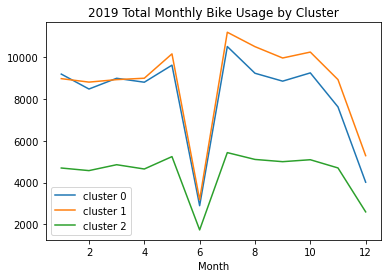

In [101]:
ax = plt.gca()

mudf_19.plot(x = "Month", y = "Cluster 0", label ="cluster 0", ax = ax)
mudf_19.plot(x = "Month", y = "Cluster 1", label ="cluster 1", ax = ax)
mudf_19.plot(x = "Month", y = "Cluster 2", label ="cluster 2", ax = ax)

plt.title("2019 Total Monthly Bike Usage by Cluster")
plt.legend()
plt.show()

[0, 0, 0, 0, 0, 0, 0, 11927.0, 10912.0, 10821.0, 9479.0, 7334.0]
[0, 0, 0, 0, 0, 0, 0, 9746.0, 9384.0, 9707.0, 9034.0, 7625.0]
[0, 0, 0, 0, 0, 0, 0, 5440.0, 4874.0, 5104.0, 4442.0, 3928.0]
    Month  Cluster 0  Cluster 1  Cluster 2
0       1        0.0        0.0        0.0
1       2        0.0        0.0        0.0
2       3        0.0        0.0        0.0
3       4        0.0        0.0        0.0
4       5        0.0        0.0        0.0
5       6        0.0        0.0        0.0
6       7        0.0        0.0        0.0
7       8    11927.0     9746.0     5440.0
8       9    10912.0     9384.0     4874.0
9      10    10821.0     9707.0     5104.0
10     11     9479.0     9034.0     4442.0
11     12     7334.0     7625.0     3928.0


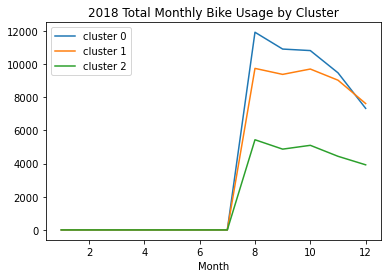

In [102]:
cluster0_usage = []
for i in months:
    cluster0_usage.append(total_monthly_bike_usage(2018, i, cluster0))
print(cluster0_usage)

cluster1_usage = []
for i in months:
    cluster1_usage.append(total_monthly_bike_usage(2018, i, cluster1))
print(cluster1_usage)

cluster2_usage = []
for i in months:
    cluster2_usage.append(total_monthly_bike_usage(2018, i, cluster2))
print(cluster2_usage)


mudf_18 = {
    'Month': months,
    "Cluster 0":cluster0_usage,
    "Cluster 1":cluster1_usage,
    "Cluster 2":cluster2_usage
}
mudf_18 = pd.DataFrame(mudf_18)
print(mudf_18)

ax = plt.gca()

mudf_18.plot(x = "Month", y = "Cluster 0", label ="cluster 0", ax = ax)
mudf_18.plot(x = "Month", y = "Cluster 1", label ="cluster 1", ax = ax)
mudf_18.plot(x = "Month", y = "Cluster 2", label ="cluster 2", ax = ax)

plt.title("2018 Total Monthly Bike Usage by Cluster")
plt.legend()
plt.show()

[2948.0, 7026.0, 4705.0, 2036.0, 3416.0, 3488.0, 3947.0, 3678.0, 3835.0, 3578.0, 3026.0, 2673.0]
[3257.0, 7815.0, 5550.0, 1891.0, 3725.0, 4368.0, 5256.0, 4733.0, 4811.0, 4265.0, 3402.0, 3815.0]
[1955.0, 4425.0, 3166.0, 1726.0, 2835.0, 2940.0, 3605.0, 3465.0, 3634.0, 3267.0, 2821.0, 2500.0]
    Month  Cluster 0  Cluster 1  Cluster 2
0       1     2948.0     3257.0     1955.0
1       2     7026.0     7815.0     4425.0
2       3     4705.0     5550.0     3166.0
3       4     2036.0     1891.0     1726.0
4       5     3416.0     3725.0     2835.0
5       6     3488.0     4368.0     2940.0
6       7     3947.0     5256.0     3605.0
7       8     3678.0     4733.0     3465.0
8       9     3835.0     4811.0     3634.0
9      10     3578.0     4265.0     3267.0
10     11     3026.0     3402.0     2821.0
11     12     2673.0     3815.0     2500.0


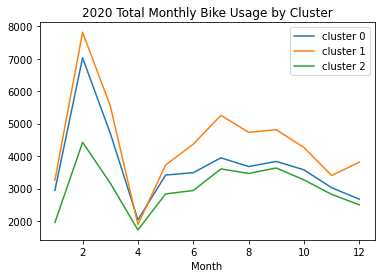

In [103]:
cluster0_usage = []
for i in months:
    cluster0_usage.append(total_monthly_bike_usage(2020, i, cluster0))
print(cluster0_usage)

cluster1_usage = []
for i in months:
    cluster1_usage.append(total_monthly_bike_usage(2020, i, cluster1))
print(cluster1_usage)

cluster2_usage = []
for i in months:
    cluster2_usage.append(total_monthly_bike_usage(2020, i, cluster2))
print(cluster2_usage)


mudf_20 = {
    'Month': months,
    "Cluster 0":cluster0_usage,
    "Cluster 1":cluster1_usage,
    "Cluster 2":cluster2_usage
}
mudf_20 = pd.DataFrame(mudf_20)
print(mudf_20)

ax = plt.gca()

mudf_20.plot(x = "Month", y = "Cluster 0", label ="cluster 0", ax = ax)
mudf_20.plot(x = "Month", y = "Cluster 1", label ="cluster 1", ax = ax)
mudf_20.plot(x = "Month", y = "Cluster 2", label ="cluster 2", ax = ax)

plt.title("2020 Total Monthly Bike Usage by Cluster")
plt.legend()
plt.show()

[2103.0, 2553.0, 3215.0, 3576.0, 3280.0, 4104.0, 4086.0, 4125.0, 4493.0, 4653.0, 3637.0, 3023.0]
[2491.0, 2752.0, 3817.0, 4500.0, 4439.0, 5183.0, 5069.0, 5236.0, 6099.0, 6369.0, 4691.0, 4562.0]
[1716.0, 1972.0, 2761.0, 2955.0, 3181.0, 3590.0, 3256.0, 3235.0, 3357.0, 3656.0, 2611.0, 2618.0]
    Month  Cluster 0  Cluster 1  Cluster 2
0       1     2948.0     3257.0     1955.0
1       2     7026.0     7815.0     4425.0
2       3     4705.0     5550.0     3166.0
3       4     2036.0     1891.0     1726.0
4       5     3416.0     3725.0     2835.0
5       6     3488.0     4368.0     2940.0
6       7     3947.0     5256.0     3605.0
7       8     3678.0     4733.0     3465.0
8       9     3835.0     4811.0     3634.0
9      10     3578.0     4265.0     3267.0
10     11     3026.0     3402.0     2821.0
11     12     2673.0     3815.0     2500.0


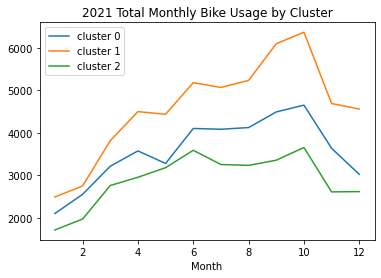

In [104]:
cluster0_usage = []
for i in months:
    cluster0_usage.append(total_monthly_bike_usage(2021, i, cluster0))
print(cluster0_usage)

cluster1_usage = []
for i in months:
    cluster1_usage.append(total_monthly_bike_usage(2021, i, cluster1))
print(cluster1_usage)

cluster2_usage = []
for i in months:
    cluster2_usage.append(total_monthly_bike_usage(2021, i, cluster2))
print(cluster2_usage)


mudf_21 = {
    'Month': months,
    "Cluster 0":cluster0_usage,
    "Cluster 1":cluster1_usage,
    "Cluster 2":cluster2_usage
}
mudf_21 = pd.DataFrame(mudf_21)
print(mudf_20)

ax = plt.gca()

mudf_21.plot(x = "Month", y = "Cluster 0", label ="cluster 0", ax = ax)
mudf_21.plot(x = "Month", y = "Cluster 1", label ="cluster 1", ax = ax)
mudf_21.plot(x = "Month", y = "Cluster 2", label ="cluster 2", ax = ax)

plt.title("2021 Total Monthly Bike Usage by Cluster")
plt.legend()
plt.show()

### Weekly

In [105]:
weeks = range(1,53)

[132.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1744.0, 2386.0, 2830.0, 2851.0, 2450.0, 2511.0, 2872.0, 2517.0, 2678.0, 2562.0, 2601.0, 2419.0, 2348.0, 1947.0, 2049.0, 2534.0, 2093.0, 2003.0, 2092.0, 1967.0, 2264.0, 623.0]
[176.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1378.0, 2149.0, 2295.0, 2050.0, 2269.0, 2196.0, 2337.0, 2076.0, 2380.0, 2132.0, 2183.0, 2245.0, 2166.0, 2019.0, 2040.0, 2318.0, 1939.0, 1975.0, 2192.0, 2017.0, 2079.0, 885.0]
[91.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 736.0, 1178.0, 1207.0, 1349.0, 1270.0, 1093.0, 1212.0, 1069.0, 1200.0, 1107.0, 1191.0, 1243.0, 1137.0, 1031.0, 997.0, 1001.0, 1036.0, 1059.0, 990.0, 976.0, 1032.0, 583.0]
    Week  Cluster 0  Cluster 1  Cluster 2
0      1      132.0      176.0       91.0
1      2        0.0        0.0        0.0
2      3        0.0        0.0        0.0
3      4        0.0        

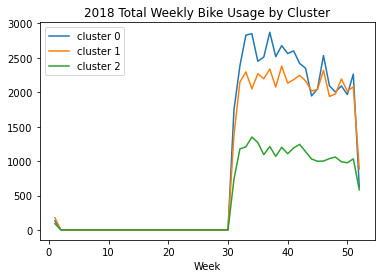

In [106]:
cluster0_usage = []
for i in weeks:
    cluster0_usage.append(total_weekly_bike_usage(2018, i, cluster0))
print(cluster0_usage)

cluster1_usage = []
for i in weeks:
    cluster1_usage.append(total_weekly_bike_usage(2018, i, cluster1))
print(cluster1_usage)

cluster2_usage = []
for i in weeks:
    cluster2_usage.append(total_weekly_bike_usage(2018, i, cluster2))
print(cluster2_usage)


wudf_18 = {
    'Week': weeks,
    "Cluster 0":cluster0_usage,
    "Cluster 1":cluster1_usage,
    "Cluster 2":cluster2_usage
}
wudf_18 = pd.DataFrame(wudf_18)
print(wudf_18)

ax = plt.gca()

wudf_18.plot(x = "Week", y = "Cluster 0", label ="cluster 0", ax = ax)
wudf_18.plot(x = "Week", y = "Cluster 1", label ="cluster 1", ax = ax)
wudf_18.plot(x = "Week", y = "Cluster 2", label ="cluster 2", ax = ax)

plt.title("2018 Total Weekly Bike Usage by Cluster")
plt.legend()
plt.show()

[1422.0, 2029.0, 2161.0, 2258.0, 2021.0, 1937.0, 2207.0, 2352.0, 2030.0, 2057.0, 2018.0, 2081.0, 2238.0, 2062.0, 2163.0, 2198.0, 1632.0, 2222.0, 1968.0, 2054.0, 2345.0, 1988.0, 1878.0, 788.0, 0, 0, 2634.0, 2258.0, 1947.0, 2567.0, 2075.0, 1906.0, 2086.0, 2195.0, 2171.0, 2109.0, 2118.0, 2079.0, 2119.0, 1961.0, 2321.0, 2055.0, 2085.0, 1674.0, 1738.0, 1939.0, 1583.0, 1919.0, 1863.0, 1179.0, 489.0, 197.0]
[1566.0, 2090.0, 2094.0, 2061.0, 2198.0, 2005.0, 2203.0, 2329.0, 2193.0, 1848.0, 2100.0, 2032.0, 2280.0, 2196.0, 2075.0, 2102.0, 1910.0, 2264.0, 2113.0, 2249.0, 2400.0, 2097.0, 1923.0, 985.0, 0, 0, 2545.0, 2405.0, 2373.0, 2725.0, 2302.0, 2114.0, 2425.0, 2439.0, 2535.0, 2321.0, 2335.0, 2426.0, 2317.0, 2145.0, 2512.0, 2355.0, 2283.0, 1972.0, 2017.0, 2259.0, 1993.0, 2119.0, 2411.0, 1421.0, 641.0, 368.0]
[794.0, 1024.0, 1144.0, 1077.0, 1180.0, 1188.0, 1158.0, 1065.0, 1119.0, 1000.0, 1031.0, 1227.0, 1231.0, 1103.0, 1071.0, 1084.0, 1053.0, 1086.0, 1019.0, 1312.0, 1271.0, 1139.0, 1020.0, 463.0, 0

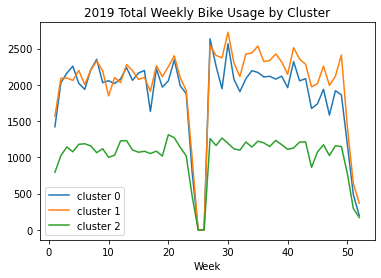

In [108]:
cluster0_usage = []
for i in weeks:
    cluster0_usage.append(total_weekly_bike_usage(2019, i, cluster0))
print(cluster0_usage)

cluster1_usage = []
for i in weeks:
    cluster1_usage.append(total_weekly_bike_usage(2019, i, cluster1))
print(cluster1_usage)

cluster2_usage = []
for i in weeks:
    cluster2_usage.append(total_weekly_bike_usage(2019, i, cluster2))
print(cluster2_usage)


wudf_19 = {
    'Week': weeks,
    "Cluster 0":cluster0_usage,
    "Cluster 1":cluster1_usage,
    "Cluster 2":cluster2_usage
}
wudf_19 = pd.DataFrame(wudf_19)
print(wudf_19)

ax = plt.gca()

wudf_19.plot(x = "Week", y = "Cluster 0", label ="cluster 0", ax = ax)
wudf_19.plot(x = "Week", y = "Cluster 1", label ="cluster 1", ax = ax)
wudf_19.plot(x = "Week", y = "Cluster 2", label ="cluster 2", ax = ax)

plt.title("2019 Total Weekly Bike Usage by Cluster")
plt.legend()
plt.show()

[384.0, 0.0, 473.0, 509.0, 1800.0, 1681.0, 1832.0, 1745.0, 1639.0, 1902.0, 1447.0, 652.0, 510.0, 382.0, 469.0, 479.0, 528.0, 550.0, 701.0, 729.0, 775.0, 944.0, 853.0, 722.0, 834.0, 834.0, 823.0, 786.0, 904.0, 924.0, 945.0, 870.0, 863.0, 779.0, 825.0, 848.0, 994.0, 941.0, 844.0, 821.0, 884.0, 862.0, 765.0, 669.0, 748.0, 672.0, 722.0, 737.0, 690.0, 753.0, 693.0, 449.0]
[557.0, 2.0, 556.0, 541.0, 1873.0, 1950.0, 1965.0, 1831.0, 1915.0, 2107.0, 1787.0, 758.0, 676.0, 362.0, 469.0, 407.0, 491.0, 495.0, 691.0, 789.0, 858.0, 1158.0, 916.0, 945.0, 1090.0, 1059.0, 1183.0, 1076.0, 1191.0, 1182.0, 1234.0, 1101.0, 1122.0, 972.0, 1136.0, 1096.0, 1193.0, 1175.0, 1078.0, 1003.0, 1047.0, 977.0, 1024.0, 688.0, 807.0, 771.0, 795.0, 862.0, 941.0, 993.0, 1053.0, 601.0]
[368.0, 0.0, 274.0, 400.0, 1160.0, 1068.0, 1055.0, 1129.0, 1026.0, 1088.0, 928.0, 555.0, 400.0, 331.0, 383.0, 373.0, 480.0, 484.0, 561.0, 581.0, 661.0, 802.0, 608.0, 631.0, 768.0, 724.0, 781.0, 711.0, 909.0, 758.0, 860.0, 856.0, 858.0, 702.0

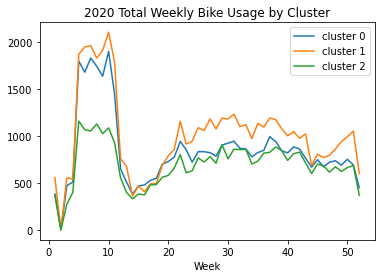

In [109]:
cluster0_usage = []
for i in weeks:
    cluster0_usage.append(total_weekly_bike_usage(2020, i, cluster0))
print(cluster0_usage)

cluster1_usage = []
for i in weeks:
    cluster1_usage.append(total_weekly_bike_usage(2020, i, cluster1))
print(cluster1_usage)

cluster2_usage = []
for i in weeks:
    cluster2_usage.append(total_weekly_bike_usage(2020, i, cluster2))
print(cluster2_usage)


wudf_20 = {
    'Week': weeks,
    "Cluster 0":cluster0_usage,
    "Cluster 1":cluster1_usage,
    "Cluster 2":cluster2_usage
}
wudf_20 = pd.DataFrame(wudf_20)
print(wudf_20)

ax = plt.gca()

wudf_20.plot(x = "Week", y = "Cluster 0", label ="cluster 0", ax = ax)
wudf_20.plot(x = "Week", y = "Cluster 1", label ="cluster 1", ax = ax)
wudf_20.plot(x = "Week", y = "Cluster 2", label ="cluster 2", ax = ax)

plt.title("2020 Total Weekly Bike Usage by Cluster")
plt.legend()
plt.show()

[485.0, 526.0, 524.0, 428.0, 616.0, 487.0, 669.0, 781.0, 632.0, 616.0, 828.0, 746.0, 917.0, 644.0, 865.0, 918.0, 876.0, 646.0, 700.0, 685.0, 854.0, 969.0, 985.0, 923.0, 901.0, 955.0, 812.0, 1044.0, 923.0, 924.0, 892.0, 904.0, 857.0, 1059.0, 1036.0, 1035.0, 1085.0, 1119.0, 930.0, 1106.0, 1151.0, 1075.0, 920.0, 1070.0, 867.0, 830.0, 868.0, 672.0, 712.0, 812.0, 516.0, 313.0]
[633.0, 574.0, 553.0, 566.0, 725.0, 555.0, 724.0, 748.0, 827.0, 721.0, 927.0, 820.0, 1130.0, 881.0, 1026.0, 1154.0, 1118.0, 849.0, 951.0, 1013.0, 1134.0, 1164.0, 1251.0, 1288.0, 1168.0, 1123.0, 978.0, 1320.0, 1142.0, 1211.0, 1070.0, 1213.0, 1159.0, 1232.0, 1305.0, 1417.0, 1461.0, 1564.0, 1303.0, 1445.0, 1557.0, 1452.0, 1338.0, 1346.0, 980.0, 1105.0, 1260.0, 852.0, 1080.0, 1329.0, 855.0, 446.0]
[433.0, 388.0, 368.0, 438.0, 500.0, 441.0, 507.0, 524.0, 600.0, 555.0, 706.0, 625.0, 622.0, 557.0, 700.0, 792.0, 732.0, 670.0, 663.0, 684.0, 825.0, 880.0, 809.0, 800.0, 851.0, 829.0, 581.0, 814.0, 745.0, 776.0, 721.0, 765.0, 674

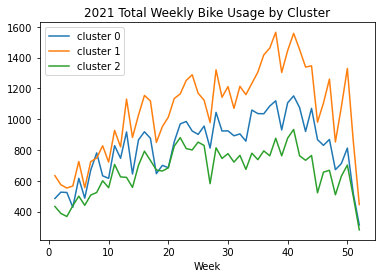

In [110]:
cluster0_usage = []
for i in weeks:
    cluster0_usage.append(total_weekly_bike_usage(2021, i, cluster0))
print(cluster0_usage)

cluster1_usage = []
for i in weeks:
    cluster1_usage.append(total_weekly_bike_usage(2021, i, cluster1))
print(cluster1_usage)

cluster2_usage = []
for i in weeks:
    cluster2_usage.append(total_weekly_bike_usage(2021, i, cluster2))
print(cluster2_usage)


wudf_21 = {
    'Week': weeks,
    "Cluster 0":cluster0_usage,
    "Cluster 1":cluster1_usage,
    "Cluster 2":cluster2_usage
}
wudf_21 = pd.DataFrame(wudf_21)
print(wudf_21)

ax = plt.gca()

wudf_21.plot(x = "Week", y = "Cluster 0", label ="cluster 0", ax = ax)
wudf_21.plot(x = "Week", y = "Cluster 1", label ="cluster 1", ax = ax)
wudf_21.plot(x = "Week", y = "Cluster 2", label ="cluster 2", ax = ax)

plt.title("2021 Total Weekly Bike Usage by Cluster")
plt.legend()
plt.show()

### Sources used for coding:
1. https://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot


2. https://www.statology.org/pandas-dropna-specific-column/


3. https://www.geeksforgeeks.org/plot-multiple-lines-in-matplotlib/


4. https://www.geeksforgeeks.org/matplotlib-pyplot-title-in-python/


5. https://sparkbyexamples.com/pandas/pandas-find-unique-values-from-columns/


6. https://stackoverflow.com/questions/18265935/how-do-i-create-a-list-with-numbers-between-two-values